Problem Statement :
In this, there is a research organistaion who has energy consumption data of world from 2008 to 2018. And to meet future requirement he want to forecast energy demand of world. So they can know that how much resourcesthey need to meet that requirment.

In our dataset we have two columns : i) date & hours ii)energy demand

So we will try it by two ways: first by normal Regression method and than Facebook FBProphet.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Import libraries

In [4]:
#installing the library
!pip install pystan==2.19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.2 MB 20 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0


In [5]:
#installing the fbprophet library
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.4 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6271371 sha256=b72d53e8a06c344bbf051baf661caf7606b767f22da8f095256a568de7835faa
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.1 requires cmdstanpy>=1.0.4, but you have cmdstanpy 0.9.5 which is incompatible.


In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [22]:

#Read the csv
df1 = pd.read_csv('/content/drive/MyDrive/Jobathon/19 11 22/train_IxoE5JN.csv',index_col=[1],
                   parse_dates=['datetime'])
#,index_col=[1]
df1.head()

,row_id,energy
datetime,,
2008-03-01 00:00:00,1,1259.985563
2008-03-01 01:00:00,2,1095.541500
2008-03-01 02:00:00,3,1056.247500
2008-03-01 03:00:00,4,1034.742000
2008-03-01 04:00:00,5,1026.334500


In [23]:
df1.describe()

,row_id,energy
count,94992.000000,93092.000000
mean,47496.500000,1702.995014
std,27421.972723,369.322103
min,1.000000,866.388600
25%,23748.750000,1431.541100
50%,47496.500000,1654.465800
75%,71244.250000,1935.993450
max,94992.000000,3374.399600


 Creating new month, year, & date column from datetime values

In [24]:
df1['year'] = df1.index.year
df1['month'] = df1.index.month
df1['day'] =df1.index.day
df1['hour'] = df1.index.hour

saal = df1['year'] - 2007
df1['saal'] = saal

df1.head()

,row_id,energy,year,month,day,hour,saal
datetime,,,,,,,
2008-03-01 00:00:00,1,1259.985563,2008,3,1,0,1
2008-03-01 01:00:00,2,1095.541500,2008,3,1,1,1
2008-03-01 02:00:00,3,1056.247500,2008,3,1,2,1
2008-03-01 03:00:00,4,1034.742000,2008,3,1,3,1
2008-03-01 04:00:00,5,1026.334500,2008,3,1,4,1


## Checking and Handling their null values

In [25]:
df1.isnull().sum()

row_id       0
energy    1900
year         0
month        0
day          0
hour         0
saal         0
dtype: int64

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   row_id  94992 non-null  int64  
 1   energy  93092 non-null  float64
 2   year    94992 non-null  int64  
 3   month   94992 non-null  int64  
 4   day     94992 non-null  int64  
 5   hour    94992 non-null  int64  
 6   saal    94992 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 5.8 MB


Added a column is_energy_null which shows that we had artificially fill nan values.

In [68]:
df1['is_energy_null'] = df1['energy'].isnull() 
df1['is_energy_null'] = df1['is_energy_null'].astype(int) 
df1.head()

,row_id,energy,year,month,day,hour,saal,is_energy_null
datetime,,,,,,,,
2008-03-01 00:00:00,1,1259.985563,2008,3,1,0,1,0
2008-03-01 01:00:00,2,1095.541500,2008,3,1,1,1,0
2008-03-01 02:00:00,3,1056.247500,2008,3,1,2,1,0
2008-03-01 03:00:00,4,1034.742000,2008,3,1,3,1,0
2008-03-01 04:00:00,5,1026.334500,2008,3,1,4,1,0


In [12]:
#So we can replace with mean or we can drop it

df1['energy'] = df1['energy'].fillna(df1['energy'].mean())
#OR
df1.fillna(method ="ffill",inplace=True)

#or

df1 = df1.dropna(axis=0)

In [13]:
df1 = df1.set_index('row_id')
df1.head()

,energy,year,month,day,hour,saal
row_id,,,,,,
1,1259.985563,2008,3,1,0,1
2,1095.541500,2008,3,1,1,1
3,1056.247500,2008,3,1,2,1
4,1034.742000,2008,3,1,3,1
5,1026.334500,2008,3,1,4,1


## Visualizing Data

In [ ]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

import pandas as pd

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	df['datetime'],
	df['energy'],
	pd.Series(df.set_index('datetime').index.to_period('Y').to_timestamp(how='end').values, index=df.index, name='datetime|Y'),
], axis=1)
chart_data = chart_data.sort_values(['datetime|Y', 'datetime'])
chart_data = chart_data.rename(columns={'datetime': 'x'})
chart_data = chart_data.dropna()
# WARNING: This is not taking into account grouping of any kind, please apply filter associated with
#          the group in question in order to replicate chart. For this we're using '"""`datetime`.dt.year == 2008"""'
chart_data = chart_data.query("""`datetime`.dt.year == 2008""")

import plotly.graph_objs as go

charts = []
charts.append(go.Bar(
	x=chart_data['x'],
	y=chart_data['energy'],
	name='(datetime.dt.year: 2008)'
))
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': '(datetime.dt.year: 2008) - energy by datetime'},
    'xaxis': {'title': {'text': 'datetime'}},
    'yaxis': {'title': {'text': 'energy'}, 'type': 'linear'}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:
#
# from plotly.offline import iplot, init_notebook_mode
#
# init_notebook_mode(connected=True)
# for chart in charts:
#     chart.pop('id', None) # for some reason iplot does not like 'id'
# iplot(figure)

## Train - Test split 

In [14]:
x = pd.DataFrame()
y = pd.DataFrame()
x = df1.drop(['energy','year'],axis=1)
y = df1['energy']

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.20,random_state = 13)

In [15]:
print(x.shape)
print(y.shape)

(94992, 4)
(94992,)


##Method 1:  simple Linear Regression and Svr to check how much it can be helpful

In [16]:

reg = LinearRegression()
model = reg.fit(x,y)

In [17]:
model.score(x,y)

0.469092079572745

In [18]:

lm = LinearRegression()
model = lm.fit(x_train,y_train)
from sklearn.metrics import mean_squared_error
y_pred = model.predict(x_test)
np.sqrt(mean_squared_error(y_test,y_pred))

266.9531584723053

In [19]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import numpy as np
regr =  SVR(C=1.0, epsilon=0.2)
regr.fit(x_train,y_train)

from sklearn.metrics import mean_squared_error
y_pred = model.predict(x_test)
np.sqrt(mean_squared_error(y_test,y_pred))

266.9531584723053

In [20]:
from sklearn.metrics import mean_squared_error
y_pred = regr.predict(x_test)
np.sqrt(mean_squared_error(y_test,y_pred))

262.0392728332464

So mean absolute error by LR and SVR are 266 and 260

## Method 2: fbprophet of facebook for univariate demand forecasting.

In [69]:
#Read the csv
df = pd.read_csv('/content/drive/MyDrive/Jobathon/19 11 22/train_IxoE5JN.csv',index_col=[0],
                   parse_dates=['datetime'])
#,index_col=[1]
df.head()

,datetime,energy
row_id,,
1,2008-03-01 00:00:00,1259.985563
2,2008-03-01 01:00:00,1095.541500
3,2008-03-01 02:00:00,1056.247500
4,2008-03-01 03:00:00,1034.742000
5,2008-03-01 04:00:00,1026.334500


In [ ]:

fig = plt.line(df, x='datetime', y='energy')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [71]:
df['energy'] = df['energy'].fillna(df['energy'].mean())

In [79]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot
df.rename(columns={'datetime': 'ds', 'energy': 'y'}, inplace=True)
train_data = df.sample(frac=0.8, random_state=10)

Converting column name to ds and y as required.

In [80]:
df.head()

,ds,y
row_id,,
1,2008-03-01 00:00:00,1259.985563
2,2008-03-01 01:00:00,1095.541500
3,2008-03-01 02:00:00,1056.247500
4,2008-03-01 03:00:00,1034.742000
5,2008-03-01 04:00:00,1026.334500


Separating out train and test data

In [81]:
validation_data = df.drop(train_data.index)

print(f'training data size : {train_data.shape}')
print(f'validation data size : {validation_data.shape}')

train_data = train_data.reset_index()
validation_data = validation_data.reset_index()

training data size : (75994, 2)
validation data size : (18998, 2)


In [82]:

from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet

Calling model and perfrming fit operation.
1. As energy demand is effected by months, just like in summer or particular month demand of energy hiked.
2. Also adding country holidays, because that time energy demand increases.

In [83]:
model = Prophet(weekly_seasonality=True, seasonality_prior_scale=0.1,yearly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_country_holidays(country_name='UK')
model.fit(df)

To check model performance evaluating on test data.

In [84]:
prediction = model.predict(pd.DataFrame({'ds':validation_data['ds']}))
y_actual = validation_data['y']
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
mean_absolute_error(y_actual, y_predicted)

134.3260412704872

Plotting resuts.

In [ ]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_actual, name="actual targets"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_predicted, name="predicted targets"),
    secondary_y=True,)
fig.update_layout(
    title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()

## Generating Result

In [87]:
test = pd.read_csv('/content/drive/MyDrive/Jobathon/19 11 22/test_WudNWDM.csv',
                   parse_dates=['datetime'])

test.head()

,row_id,datetime
0,94993,2019-01-01 00:00:00
1,94994,2019-01-01 01:00:00
2,94995,2019-01-01 02:00:00
3,94996,2019-01-01 03:00:00
4,94997,2019-01-01 04:00:00


Predicting Result

In [88]:
prediction = model.predict(pd.DataFrame({'ds':test['datetime']}))
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
print(y_predicted)

0        2036
1        1962
2        1907
3        1879
4        1883
         ... 
26299    2535
26300    2547
26301    2532
26302    2480
26303    2400
Name: yhat, Length: 26304, dtype: int64


In [89]:
test['energy'] = y_predicted
test.head()

,row_id,datetime,energy
0,94993,2019-01-01 00:00:00,2036
1,94994,2019-01-01 01:00:00,1962
2,94995,2019-01-01 02:00:00,1907
3,94996,2019-01-01 03:00:00,1879
4,94997,2019-01-01 04:00:00,1883


In [ ]:
result = pd.DataFrame()
result = test.drop(['datetime'],axis=1)
result.to_csv("result1.csv",index=False)

In [ ]:
# Until this part in Testing

## Hyper Parameter Tuning using ParameterGrid
n_changepoints is the number of change happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing n_changepoints can add value to the model.

changepoint_prior_scale to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

seasonality_mode There are 2 types model seasonality mode. Additive & multiplicaticative. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model.

holiday_prior_scale just like changepoint_prior_scale, holiday_prior_scale is used to smoothning the effect of holidays. By default its value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

Seasonalities with fourier_order Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities as add_seasonality in the model with different fourier order.Yy default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

Now, we will do the hyperparameters tuning using parametergrid. parametergrid will create all the possible parameters combination and will test the model prediction using every combination. I am taking 4 parameters: n_changepoints, changepoint_prior_scale,seasonality_mode, holiday_prior_scale for tuning.

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':['additive'],
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
               'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    print(p)
    cnt = cnt+1

print('Total Possible Models',cnt)

In [ ]:
strt='2015-05-22'
# end='2018-12-31'
# model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
# for p in grid:
#     test = pd.DataFrame()
#     print(p)
#     random.seed(0)
#     train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
#                          n_changepoints = p['n_changepoints'],
#                          seasonality_mode = p['seasonality_mode'],
#                          weekly_seasonality=True,
#                          daily_seasonality = True,
#                         #  yearly_seasonality = True,
#                          interval_width=0.95)
#     train_model.fit(X_tr)
#     # train_forecast = train_model.make_future_dataframe(periods=1095, freq='h',include_history = False)
#     train_forecast = train_model.predict(X_tst)
#     test=train_forecast[['ds','yhat']]
#     Actual = train1[(train1['ds']>strt) & (train1['ds']<=end)]
#     mse = mean_squared_error(Actual['y'], abs(test['yhat']))
#     rmse = math.sqrt(mse)
#     print('Root mean squared error(RMSE)------------------------------------',rmse)
#     model_parameters = model_parameters.append({'rmse':rmse,'Parameters':p},ignore_index=True)

In [ ]:
final_model = Prophet(changepoint_prior_scale= 0.2,
                      n_changepoints = 200,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.fit(train1)

# LSTM

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.layers import Dense,TimeDistributed,LSTM,Dropout,Bidirectional,RNN,SimpleRNN
from keras.activations import sigmoid,relu
from keras import Sequential

In [8]:

train_dataframe = pd.read_csv(r"/content/drive/MyDrive/Jobathon/19 11 22/train_IxoE5JN.csv")
train_dataframe.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


Preprocessing

In [9]:
train_dataframe.isnull().sum()

row_id         0
datetime       0
energy      1900
dtype: int64

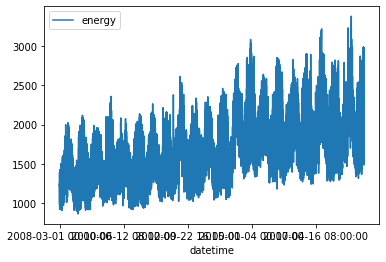

In [10]:
train_dataframe.drop(["row_id"],axis =1,inplace=True)

df_model_lstm = train_dataframe.copy(deep=False)
train_dataframe.fillna(method ="ffill",inplace=True)
train_dataframe.plot(x="datetime",y = "energy")

In [11]:


def preprocessing(input_dataframe):
  input_dataframe['datetime'] = pd.to_datetime(input_dataframe['datetime'])
  input_dataframe['day'] = input_dataframe['datetime'].dt.day
  input_dataframe['month'] = input_dataframe['datetime'].dt.month
  input_dataframe['year'] = input_dataframe['datetime'].dt.year
  input_dataframe['Time'] = input_dataframe['datetime'].dt.time
  df_hrs = input_dataframe['Time'].astype(str).str.split(':', expand=True).astype(float)
  input_dataframe["hours"] = df_hrs[0]
  input_dataframe = input_dataframe.drop(["datetime","Time"],axis=1)
  return(input_dataframe)


In [12]:
df_model_lstm = preprocessing(df_model_lstm)

In [14]:

df_model_lstm.head()

,energy,day,month,year,hours
0,1259.985563,1,3,2008,0.0
1,1095.541500,1,3,2008,1.0
2,1056.247500,1,3,2008,2.0
3,1034.742000,1,3,2008,3.0
4,1026.334500,1,3,2008,4.0


Scaling the input and ouptut value in range(0,1) for model to predict better

In [127]:
output_scaler = MinMaxScaler()
df_model_lstm['energy']=output_scaler.fit_transform(df_model_lstm['energy'].values.reshape(-1,1))


output = df_model_lstm["energy"]
df_model_lstm.drop(["energy"],axis=1,inplace=True)



scaler =MinMaxScaler()
scaler.fit(df_model_lstm)
df_model_lstm =scaler.transform(df_model_lstm)



In [134]:
train_x,val_x,train_y,val_y = train_test_split(df_model_lstm,output,test_size=0.01)




Creating single layer LSTM model


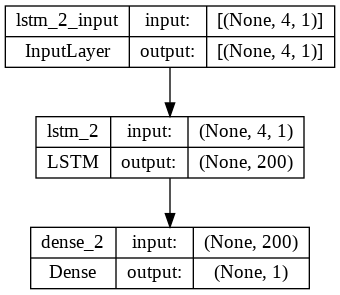

In [129]:

model = Sequential()
model.add(LSTM(200, input_shape = (train_x.shape[1],1), activation='relu'))
model.add(Dense(1))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [130]:


model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(train_x, train_y,validation_data=(val_x,val_y), epochs=20, batch_size=32,callbacks=[callback])



Epoch 1/20
2939/2939 [==============================] - 39s 13ms/step - loss: nan - mse: nan - mae: nan - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 2/20
2939/2939 [==============================] - 38s 13ms/step - loss: nan - mse: nan - mae: nan - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 3/20
2939/2939 [==============================] - 38s 13ms/step - loss: nan - mse: nan - mae: nan - val_loss: nan - val_mse: nan - val_mae: nan


In [131]:
df_test = pd.read_csv("/content/drive/MyDrive/Jobathon/19 11 22/test_WudNWDM.csv")
df_test_new = df_test.drop('row_id',axis=1)
#preprocessing_of_data
df_test_new = preprocessing(df_test_new)
df_test_min = scaler.transform(df_test_new)
output_result = model.predict(df_test_min)
df_test["energy_lstm"] = output_scaler.inverse_transform(output_result)
#df_test.drop('datetime',axis=1,inplace=True)

822/822 [==============================] - 4s 5ms/step


In [132]:
df_test.head()

,row_id,datetime,energy_lstm
0,94993,2019-01-01 00:00:00,NaN
1,94994,2019-01-01 01:00:00,NaN
2,94995,2019-01-01 02:00:00,NaN
3,94996,2019-01-01 03:00:00,NaN
4,94997,2019-01-01 04:00:00,NaN


In [ ]:
test.head()